In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import json

In [2]:
def read_img(img_path): 
    return cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2YCR_CB)[:,:,0]

In [3]:
def show_img(img_path):
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.show()

In [4]:
def print_histogram(histo):
    fig = plt.figure(figsize = (8, 4))
    plt.bar(list(range(0, 59)), histo, color ='purple', width=0.7)

In [5]:
def transition_count():
    trans_count = []
    for num in range(256):
        shifted = num >> 1
        trans_count.append(bin((shifted | (128 if num & 128 else 0)) ^ num).count("1"))
    return trans_count

In [6]:
def uniform(trans_count):
    uniform_table = []
    count = 0
    for i in range(256):
        uniform_table.append((58 if trans_count[i] > 2 else count))
        if uniform_table[-1] != 58: count += 1
    return uniform_table

In [7]:
print(*uniform(transition_count()), sep = ",")

0,1,2,3,4,58,5,6,7,58,58,58,8,58,9,10,11,58,58,58,58,58,58,58,12,58,58,58,13,58,14,15,16,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,17,58,58,58,58,58,58,58,18,58,58,58,19,58,20,21,22,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,23,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,24,58,58,58,58,58,58,58,25,58,58,58,26,58,27,28,29,30,58,31,58,58,58,32,58,58,58,58,58,58,58,33,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,34,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,35,36,37,58,38,58,58,58,39,58,58,58,58,58,58,58,40,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,41,42,43,58,44,58,58,58,45,58,58,58,58,58,58,58,46,47,48,58,49,58,58,58,50,51,52,58,53,54,55,56,57


In [8]:
def uni_LBP_array(img, uniform_table):
    rows, cols = img.shape[:2]
    lbp_array = []
    count = 0
    
    for row in range(1, (rows-1)):
        for col in range(1, (cols-1)):

            bit_array = []

            bit_array.append(1) if img[row-1][col-1] >= img[row][col] else bit_array.append(0)
            bit_array.append(1) if img[row-1][col] >= img[row][col] else bit_array.append(0)
            bit_array.append(1) if img[row-1][col+1] >= img[row][col] else bit_array.append(0)

            bit_array.append(1) if img[row][col-1] >= img[row][col] else bit_array.append(0)
            bit_array.append(1) if img[row][col+1] >= img[row][col] else bit_array.append(0)

            bit_array.append(1) if img[row+1][col-1] >= img[row][col] else bit_array.append(0)
            bit_array.append(1) if img[row+1][col] >= img[row][col] else bit_array.append(0)
            bit_array.append(1) if img[row+1][col+1] >= img[row][col] else bit_array.append(0)
            
            # binary -> decimal
            decimal = 0
            for i in range(8): decimal += bit_array[i] * 2**(7-i)

            # update the pixel values in range(0-255) to the reduced one range(0-58) thanks to Uniform-LBP
            lbp_array.append(uniform_table[decimal])
    
    return lbp_array

In [9]:
def histogram(lbp_array): 
    histo = [0.0]*59

    # frequency
    for i in range(len(lbp_array)): histo[lbp_array[i]] += 1

    # normalization
    for i in range(59): histo[i] /= len(lbp_array)
        
    return histo

In [10]:
def manhattan(histo1, histo2):
    dist = 0
    for i in range(59): dist += abs(histo1[i] - histo2[i])
    return dist

In [11]:
def save_json(file_name, dic):
    with open(file_name, "w") as outfile: json.dump(dic, outfile)

In [12]:
def read_json(file_name):
    return json.load(open(file_name))

In [13]:
def training(uniform_table):

    train_path = 'samples/train/'
    class_list = [ path for path in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, path)) ]

    train_img_names = []
    train_histograms = []

    for one_class in class_list:
        class_path = train_path + one_class + "/"    
        img_files = [path for path in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, path))] 

        for img_file in img_files:
            img_path = class_path + img_file

            img = read_img(img_path)
            lbp_array = uni_LBP_array(img, uniform_table)
            histo = histogram(lbp_array)

            train_img_names.append(img_file)
            train_histograms.append(histo)
    
    return dict(zip(train_img_names, train_histograms))

In [14]:
def test_weights(uniform_table, test_path):

    img_files = [path for path in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, path))]

    test_img_names = []
    test_histograms = []

    for img_file in img_files:
        img_path = test_path + img_file

        img = read_img(img_path)
        lbp_array = uni_LBP_array(img, uniform_table)
        histo = histogram(lbp_array)

        test_img_names.append(img_file)
        test_histograms.append(histo)

    return dict(zip(test_img_names, test_histograms))

In [15]:
# FOR ONCE
# UNIFORM-LBP TABLE
uniform_table = uniform(transition_count())

# TRAINING
train_dic = training(uniform_table)

# TEST WEIGHTS
test_dic = test_weights(uniform_table, 'samples/test/')
test_rapor_dic = test_weights(uniform_table, 'samples/testRaporaEklenecek/')

# SAVE WEIGHTS
save_json("train_set.json", train_dic)
save_json("test_set.json", test_dic)
save_json("test_rapor_set.json", test_rapor_dic)

In [1]:
# train_dic

In [17]:
# LOAD WEIGHTS
train_dic = read_json("train_set.json")
test_dic = read_json("test_set.json")
test_rapor_dic = read_json("test_rapor_set.json")

In [2]:
# test_rapor_dic

In [19]:
# FIND THE FOLDER (CLASS) OF THE IMAGE
def find_folder(img_name):
    class_list = [path for path in os.listdir(f'samples/train/') if os.path.isdir(os.path.join(f'samples/train/', path))]
    return class_list[class_list.index(img_name.split('_')[0])]

In [20]:
# DISTANCES OF ONE IMAGE
def distances(test_img_name, test_dic):
    dist = [manhattan(test_dic[test_img_name], train_dic[tr_img_name]) for tr_img_name in train_dic.keys()]
    return dict(zip(list(train_dic.keys()), dist))

In [21]:
# TESTING RESULTS
def all_test_images(test_dic):
    
    for test_img_name in list(test_dic.keys()):
        three_samples = dict(sorted(distances(test_img_name, test_dic).items(), key=lambda item: item[1])[:3])
        print(f'\n*******************\nsample: {test_img_name} ->\n\n\tImage:\t\t      Distance:')
        for sample in three_samples.keys(): print("\t{:<20}| {:<20}".format(sample, three_samples[sample]))

In [22]:
all_test_images(test_dic)


*******************
sample: banded_0013.jpg ->

	Image:		      Distance:
	banded_0006.jpg     | 0.11058865083832792 
	banded_0012.jpg     | 0.28443878870645684 
	banded_0005.jpg     | 0.3108563633740377  

*******************
sample: banded_0030.jpg ->

	Image:		      Distance:
	zigzagged_0056.jpg  | 0.12494466732394034 
	bubbly_0061.jpg     | 0.181875346502134   
	crystalline_0214.jpg| 0.20682591255839203 

*******************
sample: banded_0033.jpg ->

	Image:		      Distance:
	banded_0006.jpg     | 0.2986384181581561  
	banded_0005.jpg     | 0.41802966907569417 
	banded_0009.jpg     | 0.41821099659682903 

*******************
sample: bubbly_0073.jpg ->

	Image:		      Distance:
	honeycombed_0121.jpg| 0.15743311206592098 
	bubbly_0060.jpg     | 0.1814146395345983  
	zigzagged_0049.jpg  | 0.1964070413940691  

*******************
sample: bubbly_0075.jpg ->

	Image:		      Distance:
	bubbly_0055.jpg     | 0.11887085564906646 
	dotted_0184.jpg     | 0.1286005467088855  
	cobwebbed_004

In [23]:
found_col = []

def found_table():
    for img_name in list(test_dic.keys()):
        three_images = dict(sorted(distances(img_name, test_dic).items(), key=lambda item: item[1])[:3])
        if (img_name.split('_')[0] in list(three_images.keys())[0]) or (img_name.split('_')[0] in list(three_images.keys())[1]) or (img_name.split('_')[0] in list(three_images.keys())[2]):
            found_col.append(1)
        else: 
            found_col.append(0)

In [24]:
# results of the images found or not
found_table()
print("IMAGES\t\t\tFOUND\n")
for i in range(len(test_dic.keys())):
    print("{:<22}| {}".format(list(test_dic.keys())[i], found_col[i]))

# results of the score
class_list = [path for path in os.listdir('samples/train/') if os.path.isdir(os.path.join('samples/train/', path))]

print("\n____________________________\n\nCLASSES\t\tPERCENTAGE\n")
for a_class in class_list:
    total_class = total_true = i = 0
    for sample in list(test_dic.keys()):
        if a_class in sample:
            total_class += 1
            if found_col[i]:
                total_true += 1
        i += 1
    print('{:<15}: {}'.format(a_class, round(total_true / total_class, 2)))
print("\nTOTAL PERCENTAGE: " + str(round(found_col.count(1) / len(found_col), 2)))

IMAGES			FOUND

banded_0013.jpg       | 1
banded_0030.jpg       | 0
banded_0033.jpg       | 1
bubbly_0073.jpg       | 1
bubbly_0075.jpg       | 1
bubbly_0120.jpg       | 0
chequered_0100.jpg    | 0
chequered_0111.jpg    | 0
chequered_0176.jpg    | 0
cobwebbed_0120.jpg    | 0
cobwebbed_0122.jpg    | 0
cobwebbed_0126.jpg    | 1
crystalline_0111.jpg  | 1
crystalline_0114.jpg  | 1
crystalline_0116.jpg  | 0
dotted_0062.jpg       | 1
dotted_0072.jpg       | 0
dotted_0090.jpg       | 0
honeycombed_0003.jpg  | 1
honeycombed_0045.jpg  | 1
honeycombed_0150.jpg  | 1
striped_0076.jpg      | 1
striped_0100.jpg      | 1
striped_0122.jpg      | 1
zigzagged_0008.jpg    | 1
zigzagged_0009.jpg    | 0
zigzagged_0014.jpg    | 1

____________________________

CLASSES		PERCENTAGE

banded         : 0.67
bubbly         : 0.67
chequered      : 0.0
cobwebbed      : 0.33
crystalline    : 0.67
dotted         : 0.33
honeycombed    : 1.0
striped        : 1.0
zigzagged      : 0.67

TOTAL PERCENTAGE: 0.59


In [25]:
# TESTING IMAGE RESULTS
def print_all_test_images(test_dic, test_path):
    
    for test_img_name in list(test_dic.keys()):
        three_samples = dict(sorted(distances(test_img_name, test_dic).items(), key=lambda item: item[1])[:3])
        img_paths = []
        
        # for the test image
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(1, 4, 1)
        plt.imshow(mpimg.imread(test_path + test_img_name))
        ax.set_title(test_img_name)
        
        for sample in three_samples: img_paths.append('samples/train/' + find_folder(sample) + '/' + sample)
    
        for i in range(2, 5):
            ax = fig.add_subplot(1, 4, i)
            plt.imshow(mpimg.imread(img_paths[i-2]))
            ax.set_title(list(three_samples.keys())[i-2])
            ax.set_xlabel(f'dist: {list(three_samples.values())[i-2]}')

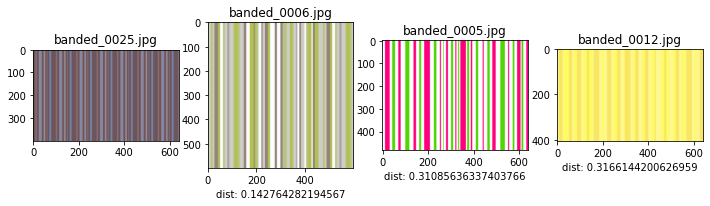

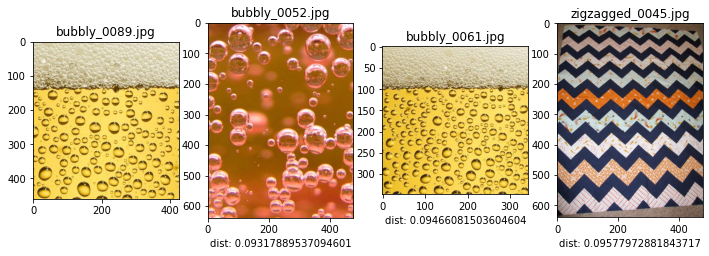

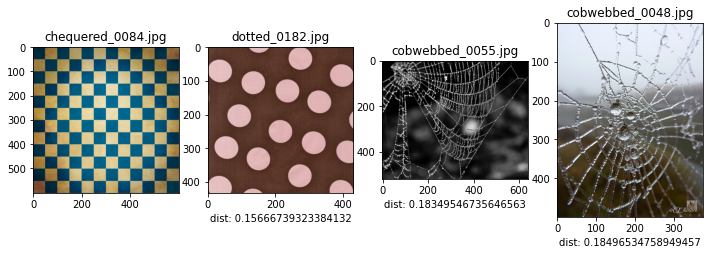

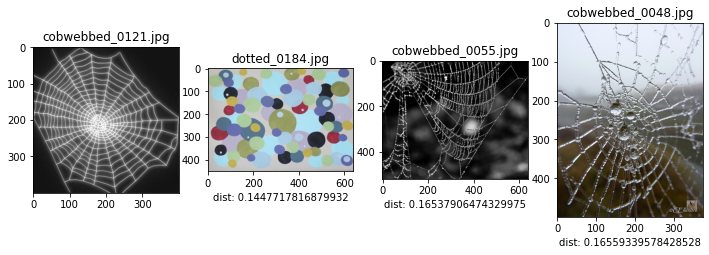

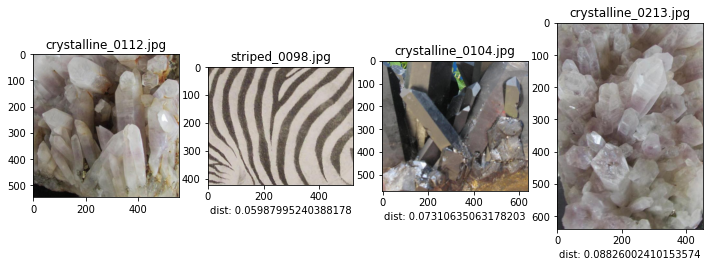

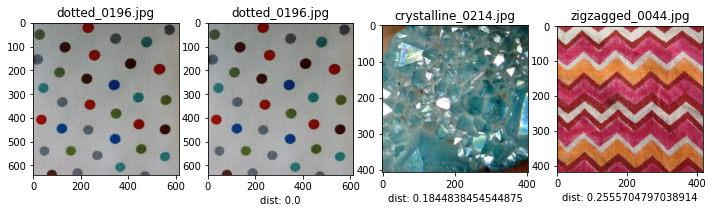

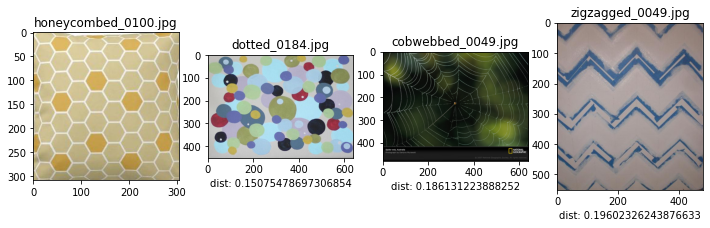

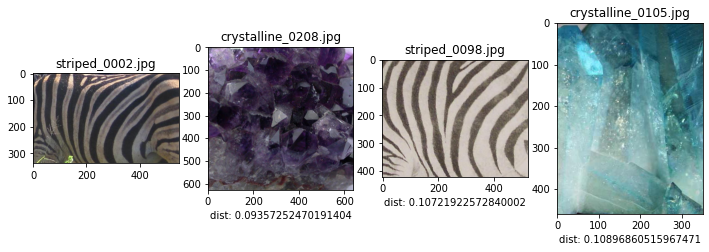

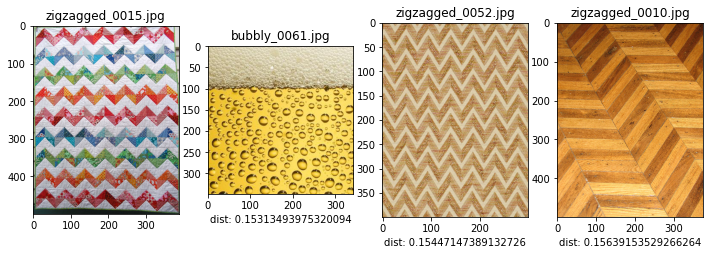

In [26]:
print_all_test_images(test_rapor_dic, 'samples/testRaporaEklenecek/')

In [27]:
# ONE INPUT
"""def one_image(test_img_name):
    three_classes = dict(sorted(distances(test_img_name).items(), key=lambda item: item[1])[:3])
    print(f'\n**********************\n{test_img_name} ->\n')
    for key, value in three_classes.items(): print(f'\t{key}: {value}')"""

"def one_image(test_img_name):\n    three_classes = dict(sorted(distances(test_img_name).items(), key=lambda item: item[1])[:3])\n    print(f'\n**********************\n{test_img_name} ->\n')\n    for key, value in three_classes.items(): print(f'\t{key}: {value}')"

In [28]:
#test_img_name = input("File name: ")
#one_image(test_img_name)

In [29]:
#print(print_histogram(train_dic["banded_0006.jpg"]))